# Operator with obstacles

If you want to use these operators out of the `FieldOperations` class, you can also simply create them as follows:



In this tutorial, we will show you how build operators when there are obstacles inside the computational domain.

<a target="_blank" href="https://colab.research.google.com/github/qiauil/ConvDO/blob/main//docs/contents/examples/obstacles.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In many situations, the flow field may contain obstacles. For example, the flow around a cylinder is a classical problem in fluid dynamics. The flow field around a cylinder is illustrated as follows:

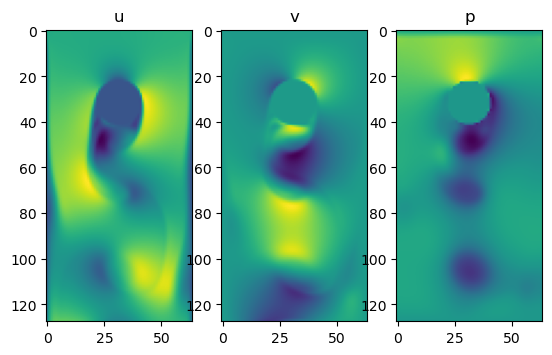

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

cyclinder_flow=torch.from_numpy(np.load("../../binaries/cyclinder.npy"))
channel_names=["u","v","p"]
figs, axs = plt.subplots(1, 3)
for i, ax in enumerate(axs):
    ax.imshow(cyclinder_flow[i,:,:].numpy())
    ax.set_title(channel_names[i])
plt.show()

Besides the divergence free condition, the flow field should also satisfy the Momentum equation. The Momentum equation is a vector equation, which can be written as follows:

$$
\left\{\begin{matrix}
{{\partial u} \over {\partial t}} + {u {{\partial u} \over {\partial x}}} + v {{\partial u} \over {\partial y}} = -{1 \over \rho} {{\partial p} \over {\partial x}} + \nu \left( {{\partial^2 u} \over {\partial x^2}} + {{\partial^2 u} \over {\partial y^2}} \right)

 \\
{{\partial v} \over {\partial t}} + {u {{\partial v} \over {\partial x}}} + v {{\partial v} \over {\partial y}} = -{1 \over \rho} {{\partial p} \over {\partial y}} + \nu \left( {{\partial^2 v} \over {\partial x^2}} + {{\partial^2 v} \over {\partial y^2}} \right)

\end{matrix}\right.
$$

The above equation contains the transient derivative, which is hard to evaluate if we only have a snapshot of the flow field. Therefore, we can combine the divergence-free condition with the momentum equation to the [Poisson equation for pressure](http://127.0.0.1:8000/ConvDO/contents/examples/operator/):

$$
-{1 \over \rho} \left( {{\partial^2 p} \over {\partial x^2}} + {{\partial^2 p} \over {\partial y^2}} \right) = \left( {{\partial u} \over {\partial x}} \right)^2 + 2 {{\partial u} \over {\partial y}} {{\partial v} \over {\partial x}}+ \left( {{\partial v} \over {\partial y}} \right)^2
$$

To calculate the residual of Poisson equation and the divergence of the velocity field, we can build a operator as follows (for incompressible flow, the density $\rho$ is omitted):

In [2]:
from ConvDO import *

class PoissonDivergence(FieldOperations):
    def __init__(self, 
                 domain_u: Domain,
                 domain_v: Domain, 
                 domain_p: Domain, 
                 order: int,
                 device="cpu", 
                 dtype=torch.float32) -> None:
        super().__init__(order, device=device, dtype=dtype)
        self.pressure = ScalarField(domain=domain_p)
        self.velocity = VectorValue(ScalarField(domain=domain_u), ScalarField(domain=domain_v))

    def __call__(self, u, v, p):
        self.velocity.ux.register_value(u)
        self.velocity.uy.register_value(v)
        self.pressure.register_value(p)
        poisson = (self.nabla2*self.pressure)+(self.grad_x*self.velocity.ux)**2+2*(self.grad_y*self.velocity.ux)*(self.grad_x*self.velocity.uy)+(self.grad_y*self.velocity.uy)**2
        divergence = self.nabla@self.velocity
        return torch.cat([poisson.value, divergence.value], dim=-3)

You may notice that there is a cyclinder in the flow field. We can add the cylinder as an obstacle in the domain. The `Obstacle` class is used to add obstacles in the domain. The `Obstacle` class is initialized with the shape of the obstacle. The shape of the obstacle is a binary tensor with the same shape as the domain. The obstacle is a tensor with 0 and 1, where 0 represents the obstacle and 1 represents the calculation domain. The following code shows how generate a cylinder obstacle shape::

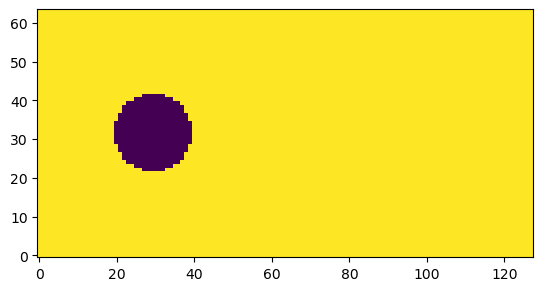

In [3]:
def generate_cylinder_2D(center_x,center_y,radius,length_x,length_y,dx=1,dy=1):
    y, x=np.ogrid[0.5:int(length_y/dy)+0.5, 0.5:int(length_x/dx)+0.5]
    x=x*dx
    y=y*dy
    dist_from_center = torch.tensor(np.sqrt((x - center_x)**2 + (y-center_y)**2))
    return torch.where(dist_from_center < radius,0.0,1.0)

# generate_cylinder_2D function is also available in the ConvDO module
obstacles=generate_cylinder_2D(30,32,10,128,64)

plt.imshow(obstacles,origin="lower")

Then we can build the domain where we can specify the boundary condition for each filed on the boundaries and obstacles:

In [4]:
domain_u=Domain(
    boundaries=[
        UnConstrainedBoundary(),
        UnConstrainedBoundary(),
        DirichletBoundary(0.45), # inflow
        UnConstrainedBoundary()
    ],
    obstacles=[DirichletObstacle(shape_field=obstacles,boundary_value=0.0)]
)

domain_v=Domain(
    boundaries=[
        UnConstrainedBoundary(),
        UnConstrainedBoundary(),
        DirichletBoundary(0),
        UnConstrainedBoundary()
    ],
    obstacles=[DirichletObstacle(shape_field=obstacles,boundary_value=0.0)]
)

domain_p=Domain(
    boundaries=[
        UnConstrainedBoundary(),
        UnConstrainedBoundary(),
        NeumannBoundary(0.0),
        UnConstrainedBoundary()
    ],
    obstacles=[NeumannObstacle(shape_field=obstacles,boundary_gradient=0.0)]
)

Now, let's calculate the residual of the Poisson equation and the divergence of the velocity field:

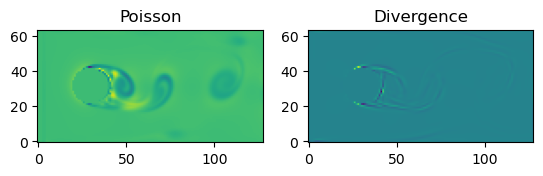

In [5]:
u=cyclinder_flow[0]
v=cyclinder_flow[1]
p=cyclinder_flow[2]
operator=PoissonDivergence(domain_u,domain_v,domain_p,order=2)
residual=operator(u.T,-1*v.T,p.T)
channel_names=["Poisson","Divergence"]
figs, axs = plt.subplots(1, 2)
for i, ax in enumerate(axs):
    ax.imshow(residual[0,i,:,:].numpy(),origin="lower")
    ax.set_title(channel_names[i])
plt.show()

You may wonder why we perform the transpose and change the sign of the y component of the velocity field. This is related to the coordinate system of the field in `ConvDO`. The following code clearly shows the difference between `ConvDO`'s $x,y$ coordinates and Torch/Numpy's `Row/Column` coordinates

torch.Size([1, 1, 64, 128])


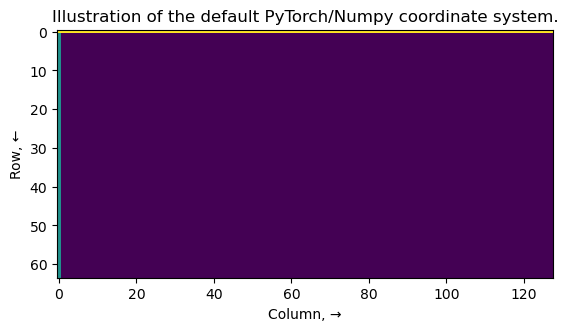

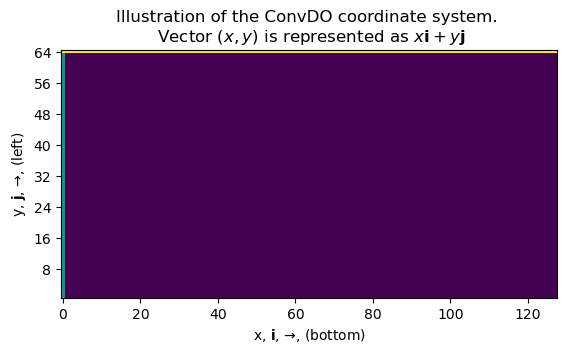

In [7]:
import torch
import matplotlib.pyplot as plt
field=torch.zeros(1,1,63,127)
# left boundary
field=torch.nn.functional.pad(field,(1,0,0,0),mode="constant",value=1)
# top boundary
field=torch.nn.functional.pad(field,(0,0,1,0),mode="constant",value=2)
print(field.shape)
# mesh: 128(x) * 64(y)

plt.imshow(field.squeeze().squeeze().numpy())
plt.xlabel("Column, →")
plt.ylabel("Row, ←")
plt.title("Illustration of the default PyTorch/Numpy coordinate system.")
plt.show()

plt.imshow(field.squeeze().squeeze().numpy())
plt.xlabel("x, $\mathbf{i}$, →, (bottom)")
plt.ylabel("y, $\mathbf{j}$, →, (left)")
plt.yticks(range(0,64,8),[64-i for i in range(0,64,8)])
plt.title("Illustration of the ConvDO coordinate system. \n Vector $(x,y)$ is represented as $x \mathbf{i}+y \mathbf{j}$")
plt.show()

In the original cylinder flow field, the $x$ component of the velocity actually points to $-y$ direction and the $y$ component actually points to $x$ direction. Thus, we need to do some modifications on their direction. It is always ideal to check the coordinate system of your data before calculate the residual.